In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
consume = ['KO','ABEV','MCD','ARCO','WMT','PG','NKE','PEP','COST','MO']

In [3]:
df = yahoo.download(consume,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  10 of 10 completed


NKE     1.321783
COST    1.242357
WMT     1.197525
PG      1.154800
PEP     1.056174
MCD     0.952261
MO      0.927419
KO      0.903075
ARCO    0.689265
ABEV    0.524625
dtype: float64

In [4]:
df

,ABEV,ARCO,COST,KO,MCD,MO,NKE,PEP,PG,WMT
Datetime,,,,,,,,,,
2019-08-15 09:30:00-04:00,4.670,7.050987,270.510010,53.650002,217.429993,45.880001,80.519997,130.130096,116.989998,110.720001
2019-08-15 10:30:00-04:00,4.673,7.120066,270.859985,53.689999,217.455002,45.970001,80.440002,130.100006,117.370003,111.750000
2019-08-15 11:30:00-04:00,4.670,7.203948,270.899994,53.849998,218.089996,45.889999,79.915001,130.419998,117.760002,110.839996
2019-08-15 12:30:00-04:00,4.650,7.189737,270.510010,53.815300,217.509995,45.625000,79.830002,130.869995,117.639999,110.894997
2019-08-15 13:30:00-04:00,4.635,7.185394,270.867096,53.810001,217.440002,45.564999,79.580002,130.910004,117.581001,111.269997
...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,2.485,4.810000,337.350006,48.500000,206.660004,42.575001,106.495003,137.854996,134.910004,132.320099
2020-08-14 12:30:00-04:00,2.450,4.820000,337.079987,48.438801,207.050003,42.575001,106.419998,137.809998,134.889999,132.604996
2020-08-14 13:30:00-04:00,2.460,4.827500,336.899994,48.474998,207.179993,42.630001,106.550003,137.690002,135.149994,132.785004


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = 20
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

WMT     0.300
COST    0.300
PG      0.138
MCD     0.129
MO      0.110
KO      0.082
NKE     0.060
ARCO   -0.030
ABEV   -0.043
PEP    -0.046
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


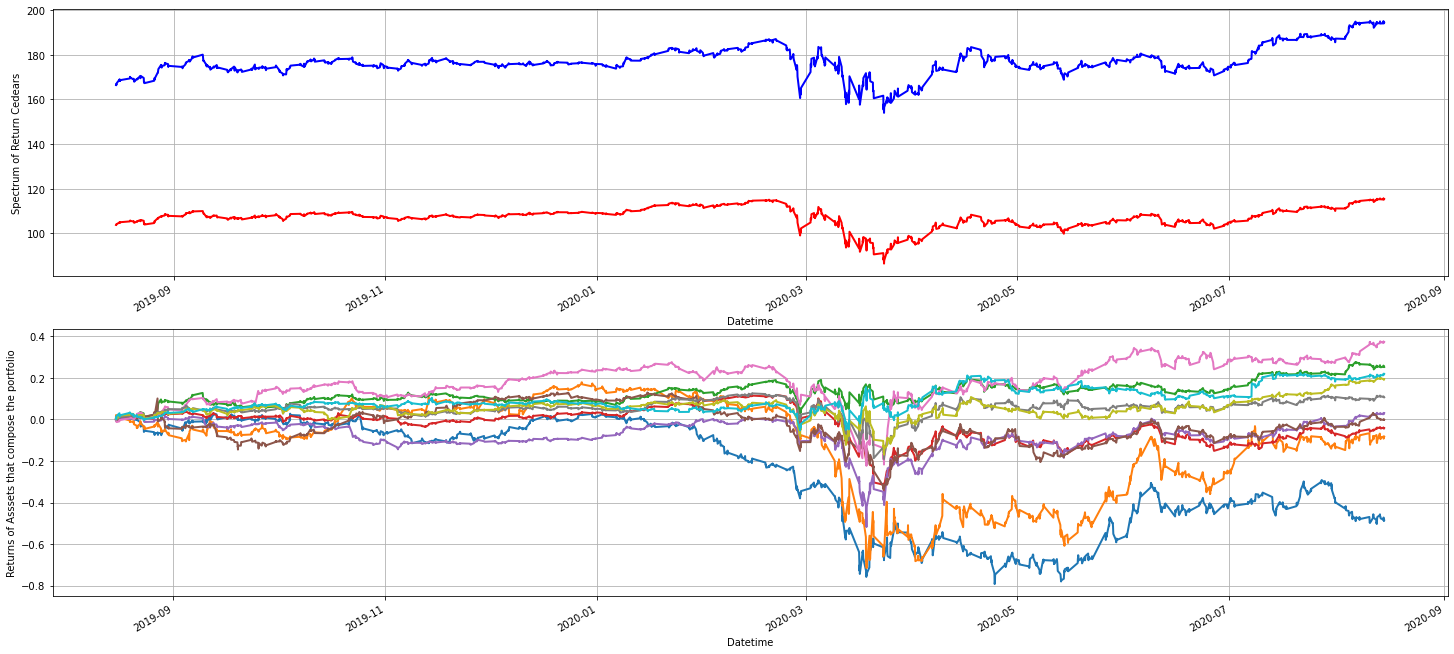

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00    166.441068
 2019-08-15 10:30:00-04:00    166.918290
 2019-08-15 11:30:00-04:00    166.748738
 2019-08-15 12:30:00-04:00    166.500354
 2019-08-15 13:30:00-04:00    166.679709
                                 ...    
 2020-08-14 11:30:00-04:00    194.635218
 2020-08-14 12:30:00-04:00    194.680987
 2020-08-14 13:30:00-04:00    194.755323
 2020-08-14 14:30:00-04:00    194.140541
 2020-08-14 15:30:00-04:00    194.417062
 Length: 1765, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00    103.755108
 2019-08-15 10:30:00-04:00    103.942806
 2019-08-15 11:30:00-04:00    103.953893
 2019-08-15 12:30:00-04:00    103.853503
 2019-08-15 13:30:00-04:00    103.884350
                                 ...    
 2020-08-14 11:30:00-04:00    115.396011
 2020-08-14 12:30:00-04:00    115.413878
 2020-08-14 13:30:00-04:00    115.464749
 2020-08-14 14:30:00-04:00    115.127680
 2020-08-14 15:30:00-04:00    115.299002
 Length: 1765, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

WMT     0.30
COST    0.30
PG      0.14
MCD     0.13
MO      0.11
KO      0.08
NKE     0.06
ARCO   -0.03
ABEV   -0.04
PEP    -0.05
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00    166.278668
2019-08-15 10:30:00-04:00    166.756724
2019-08-15 11:30:00-04:00    166.586978
2019-08-15 12:30:00-04:00    166.335983
2019-08-15 13:30:00-04:00    166.514956
                                ...    
2020-08-14 11:30:00-04:00    194.470733
2020-08-14 12:30:00-04:00    194.517049
2020-08-14 13:30:00-04:00    194.592473
2020-08-14 14:30:00-04:00    193.976891
2020-08-14 15:30:00-04:00    194.255002
Length: 1765, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
ABEV,0.1,0.449578,0.013431,0.018115,0.144495
ARCO,0.1,0.417303,0.018238,0.022832,0.144495
COST,0.1,0.525139,0.006374,0.010042,0.144495
KO,0.1,0.588612,0.008234,0.014540,0.144495
MCD,0.1,0.512006,0.009536,0.014647,0.144495
MO,0.1,0.498784,0.009146,0.013686,0.144495
NKE,0.1,0.526528,0.010323,0.016307,0.144495
PEP,0.1,0.584647,0.007702,0.013509,0.144495
PG,0.1,0.532948,0.007616,0.012177,0.144495
WMT,0.1,0.432276,0.006662,0.008640,0.144495


In [15]:
poe, fullstress

(ABEV    -8.537064
 ARCO   -10.607064
 COST    -9.225881
 KO     -10.880146
 MCD    -12.387337
 MO      -8.069513
 NKE    -11.692478
 PEP    -11.639404
 PG      -7.797277
 WMT     -8.119834
 dtype: float64,
 -1.4525615841503683)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00    103.755108
2019-08-15 10:30:00-04:00    103.942806
2019-08-15 11:30:00-04:00    103.953893
2019-08-15 12:30:00-04:00    103.853503
2019-08-15 13:30:00-04:00    103.884350
                                ...    
2020-08-14 11:30:00-04:00    115.396011
2020-08-14 12:30:00-04:00    115.413878
2020-08-14 13:30:00-04:00    115.464749
2020-08-14 14:30:00-04:00    115.127680
2020-08-14 15:30:00-04:00    115.299002
Length: 1765, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
ABEV,0.000284,-0.013736,0.020695,0.009304,0.041829,0.004183,0.044263,0.094501
ARCO,0.000363,-0.013736,0.026449,0.011037,0.046058,0.004606,0.044263,0.104056
COST,0.000153,-0.013736,0.011128,0.005844,0.030688,0.003069,0.044263,0.069331
KO,0.000270,-0.013736,0.019690,0.011590,0.068218,0.006822,0.044263,0.154120
MCD,0.000252,-0.013736,0.018316,0.009378,0.048017,0.004802,0.044263,0.108480
MO,0.000216,-0.013736,0.015737,0.007849,0.039150,0.003915,0.044263,0.088449
NKE,0.000282,-0.013736,0.020509,0.010798,0.056856,0.005686,0.044263,0.128450
PEP,0.000236,-0.013736,0.017195,0.010053,0.058775,0.005878,0.044263,0.132787
PG,0.000189,-0.013736,0.013760,0.007334,0.039084,0.003908,0.044263,0.088299
WMT,0.000103,-0.013736,0.007468,0.003228,0.013955,0.001395,0.044263,0.031527


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
ABEV,0.1,0.094501,-0.04,0.009450,-0.003780,-0.013230,-1.4,0.016,2.436,0.006568
ARCO,0.1,0.104056,-0.03,0.010406,-0.003122,-0.013527,-1.3,0.009,2.436,0.003695
COST,0.1,0.069331,0.30,0.006933,0.020799,0.013866,2.0,0.900,2.436,0.369458
KO,0.1,0.154120,0.08,0.015412,0.012330,-0.003082,-0.2,0.064,2.436,0.026273
MCD,0.1,0.108480,0.13,0.010848,0.014102,0.003254,0.3,0.169,2.436,0.069376
MO,0.1,0.088449,0.11,0.008845,0.009729,0.000884,0.1,0.121,2.436,0.049672
NKE,0.1,0.128450,0.06,0.012845,0.007707,-0.005138,-0.4,0.036,2.436,0.014778
PEP,0.1,0.132787,-0.05,0.013279,-0.006639,-0.019918,-1.5,0.025,2.436,0.010263
PG,0.1,0.088299,0.14,0.008830,0.012362,0.003532,0.4,0.196,2.436,0.080460
WMT,0.1,0.031527,0.30,0.003153,0.009458,0.006305,2.0,0.900,2.436,0.369458


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

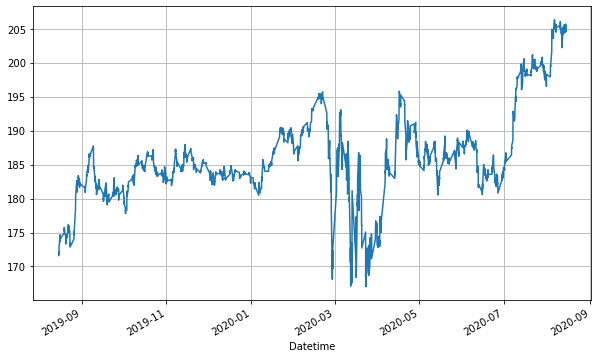

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00    171.616564
2019-08-15 10:30:00-04:00    172.163022
2019-08-15 11:30:00-04:00    171.913073
2019-08-15 12:30:00-04:00    171.728521
2019-08-15 13:30:00-04:00    171.982875
                                ...    
2020-08-14 11:30:00-04:00    205.127182
2020-08-14 12:30:00-04:00    205.154755
2020-08-14 13:30:00-04:00    205.189164
2020-08-14 14:30:00-04:00    204.573020
2020-08-14 15:30:00-04:00    204.788516
Length: 1765, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

COST    0.369458
WMT     0.369458
PG      0.080460
MCD     0.069376
MO      0.049672
KO      0.026273
NKE     0.014778
PEP     0.010263
ABEV    0.006568
ARCO    0.003695
Name: MinCVaR, dtype: float64